# Loading Data and Preprocessing


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(color_codes=True)

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('total_rookies_stats.csv')
df.head()

,Unnamed: 0,Player,Tm,Age,Yrs,G,MP,FG,FGA,3P,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,0,James Bailey,SEA,22.0,1.0,67.0,726.0,122.0,271.0,0.0,...,0.0,0.0,Seattle SuperSonics,56,26,0.683,4.0,108.5,103.8,4.24
1,1,Vinnie Johnson,SEA,23.0,1.0,38.0,325.0,45.0,115.0,0.0,...,0.0,0.0,Seattle SuperSonics,56,26,0.683,4.0,108.5,103.8,4.24
2,2,Billy Ray Bates,POR,23.0,1.0,16.0,235.0,72.0,146.0,8.0,...,0.0,0.0,Portland Trail Blazers,38,44,0.463,22.0,102.5,103.3,-0.87
3,3,Abdul Jeelani,POR,25.0,1.0,77.0,1286.0,288.0,565.0,0.0,...,0.0,0.0,Portland Trail Blazers,38,44,0.463,22.0,102.5,103.3,-0.87
4,4,Jim Paxson,POR,22.0,1.0,72.0,1270.0,189.0,460.0,1.0,...,0.0,0.0,Portland Trail Blazers,38,44,0.463,22.0,102.5,103.3,-0.87


In [3]:
df.drop(['Unnamed: 0', 'Tm'], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   3265 non-null   object 
 1   Age      3265 non-null   float64
 2   Yrs      3265 non-null   float64
 3   G        3265 non-null   float64
 4   MP       3265 non-null   float64
 5   FG       3265 non-null   float64
 6   FGA      3265 non-null   float64
 7   3P       3265 non-null   float64
 8   3PA      3265 non-null   float64
 9   FT       3265 non-null   float64
 10  FTA      3265 non-null   float64
 11  ORB      3265 non-null   float64
 12  TRB      3265 non-null   float64
 13  AST      3265 non-null   float64
 14  STL      3265 non-null   float64
 15  BLK      3265 non-null   float64
 16  TOV      3265 non-null   float64
 17  PF       3265 non-null   float64
 18  PTS      3265 non-null   float64
 19  FG%      3231 non-null   float64
 20  3P%      2586 non-null   float64
 21  FT%      2998 

In [4]:
# check if missing values present in data and remove rows with missing values
if df.isnull().values.any():
    df = df.dropna()

# drop duplicate rows
df = df.drop_duplicates()

df = df.reset_index()

df.shape

(2458, 39)

## Create new features and target feature

In [5]:
year_champ = np.arange(1980, 2024, 1)

In [6]:
print(year_champ)

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023]


In [7]:
team_champ = ['Los Angeles Lakers', 'Boston Celtics', 'Los Angeles Lakers', 'Philadelphia 76ers', 'Boston Celtics',
              'Los Angeles Lakers', 'Boston Celtics', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Detroit Pistons',
              'Detroit Pistons', 'Chicago Bulls', 'Chicago Bulls', 'Chicago Bulls', 'Houston Rockets',
              'Houston Rockets ', 'Chicago Bulls', 'Chicago Bulls', 'Chicago Bulls', 'San Antonio Spurs',
              'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'San Antonio Spurs', 'Detroit Pistons',
              'San Antonio Spurs', 'Miami Heat', 'San Antonio Spurs', 'Boston Celtics', 'Los Angeles Lakers',
              'Los Angeles Lakers', 'Dallas Mavericks', 'Miami Heat', 'Miami Heat', 'San Antonio Spurs',
              'Golden State Warriors', 'Cleveland Cavaliers', 'Golden State Warriors', 'Golden State Warriors', 'Toronto Raptors',
              'Los Angeles Lakers', 'Milwaukee Bucks', 'Golden State Warriors ', 'Denver Nuggets']
              

In [8]:
champ = []
for i in range(len(df.Year)):
    idx = np.where(year_champ == df['Year'][i])[0][0]
    champ.append(team_champ[idx])

winner = [i==j for i, j in zip(champ, df.Team)]
winner = [i*1 for i in winner]

df['Winner'] = winner

df.head()

,index,Player,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,Winner
0,1,Vinnie Johnson,23.0,1.0,38.0,325.0,45.0,115.0,0.0,1.0,...,0.000,Seattle SuperSonics,56,26,0.683,4.0,108.5,103.8,4.24,0
1,2,Billy Ray Bates,23.0,1.0,16.0,235.0,72.0,146.0,8.0,19.0,...,0.000,Portland Trail Blazers,38,44,0.463,22.0,102.5,103.3,-0.87,0
2,3,Abdul Jeelani,25.0,1.0,77.0,1286.0,288.0,565.0,0.0,6.0,...,0.000,Portland Trail Blazers,38,44,0.463,22.0,102.5,103.3,-0.87,0
3,4,Jim Paxson,22.0,1.0,72.0,1270.0,189.0,460.0,1.0,22.0,...,0.000,Portland Trail Blazers,38,44,0.463,22.0,102.5,103.3,-0.87,0
4,5,Larry Bird,23.0,1.0,82.0,2955.0,693.0,1463.0,58.0,143.0,...,0.955,Boston Celtics,61,21,0.744,0.0,113.5,105.7,7.37,0


In [9]:
with open('rookie_win.txt', 'r') as rookie:
    Winner_Rookie_Year = rookie.read().split('\n')

champ_rookie = []
for i in range(len(df.Player)):
    if df['Player'][i] in Winner_Rookie_Year:
        champ_rookie.append(1)
    else:
        champ_rookie.append(0)

df['Winner_Rookie'] = champ_rookie

## 1. Exploratory Data Analysis

In [10]:
# check if the dataset is balanced with respect to the target feature

df['Winner_Rookie'].value_counts()

Winner_Rookie
0    2412
1      46
Name: count, dtype: int64

## 1.1 Categorical data

In [11]:
cat = df.columns[df.dtypes == "object"]

print(cat)

Index(['Player', 'Team'], dtype='object')


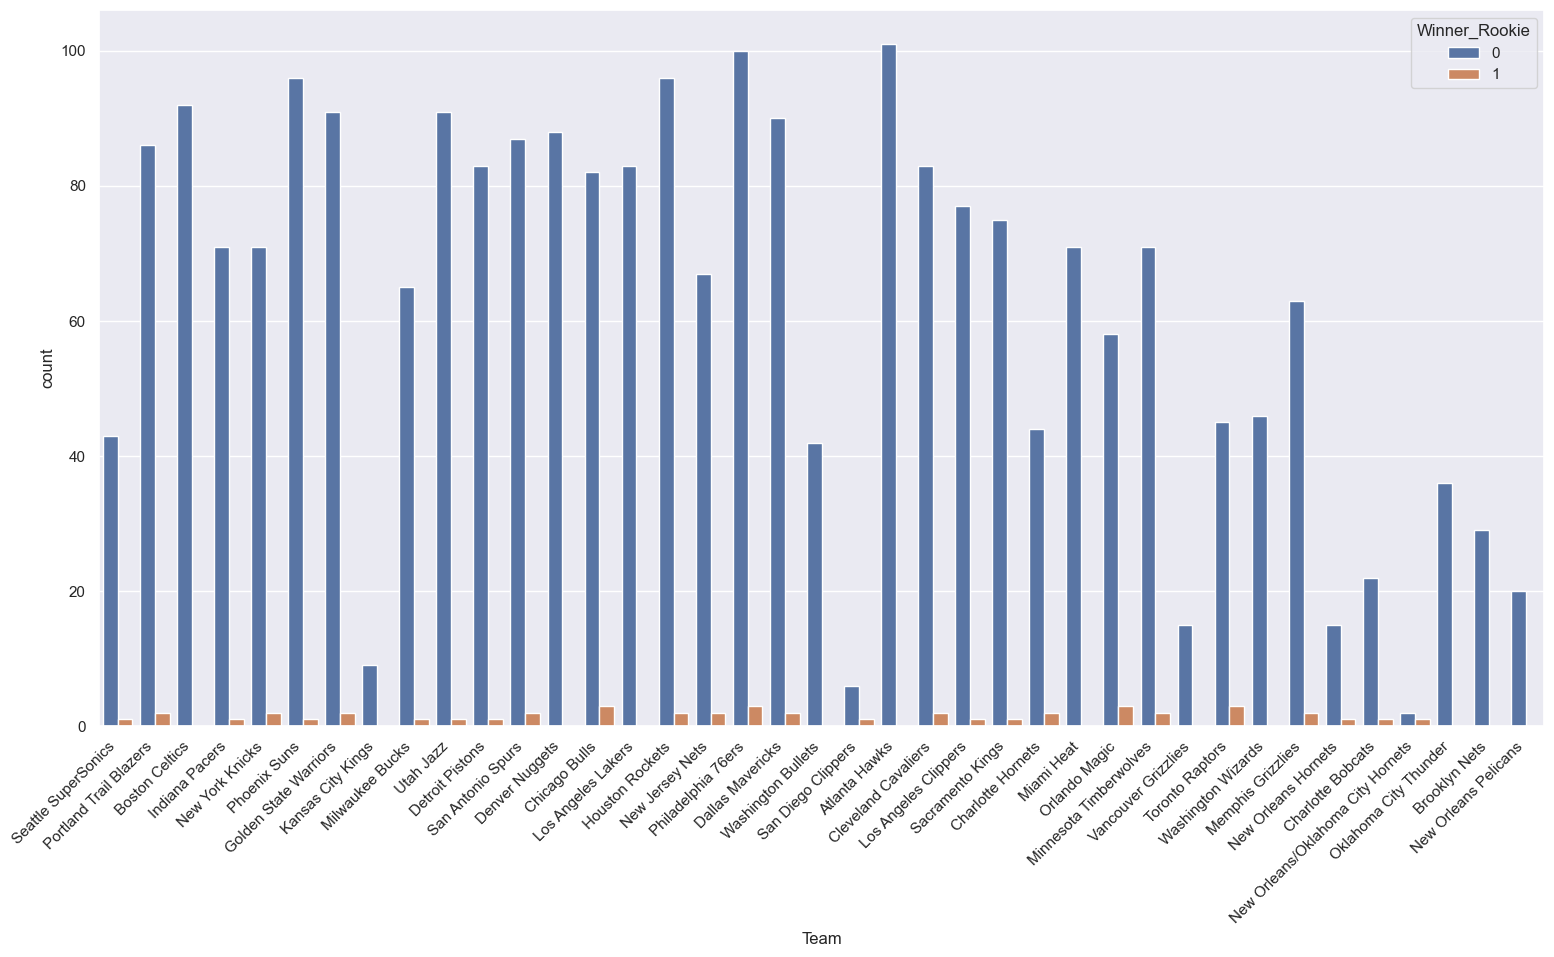

In [12]:
# list of categorical variables to plot
cat_vars = ['Team']

# create figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

# create barplot for each categorical variable
for i, var in enumerate(cat_vars):
    sns.countplot(x=var, hue='Winner_Rookie', data=df, ax=axs)
    #axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# adjust spacing between subplots
fig.tight_layout()

plt.xticks(rotation=45, ha='right')

# show plot
plt.show()


## 1.2 Numerical data

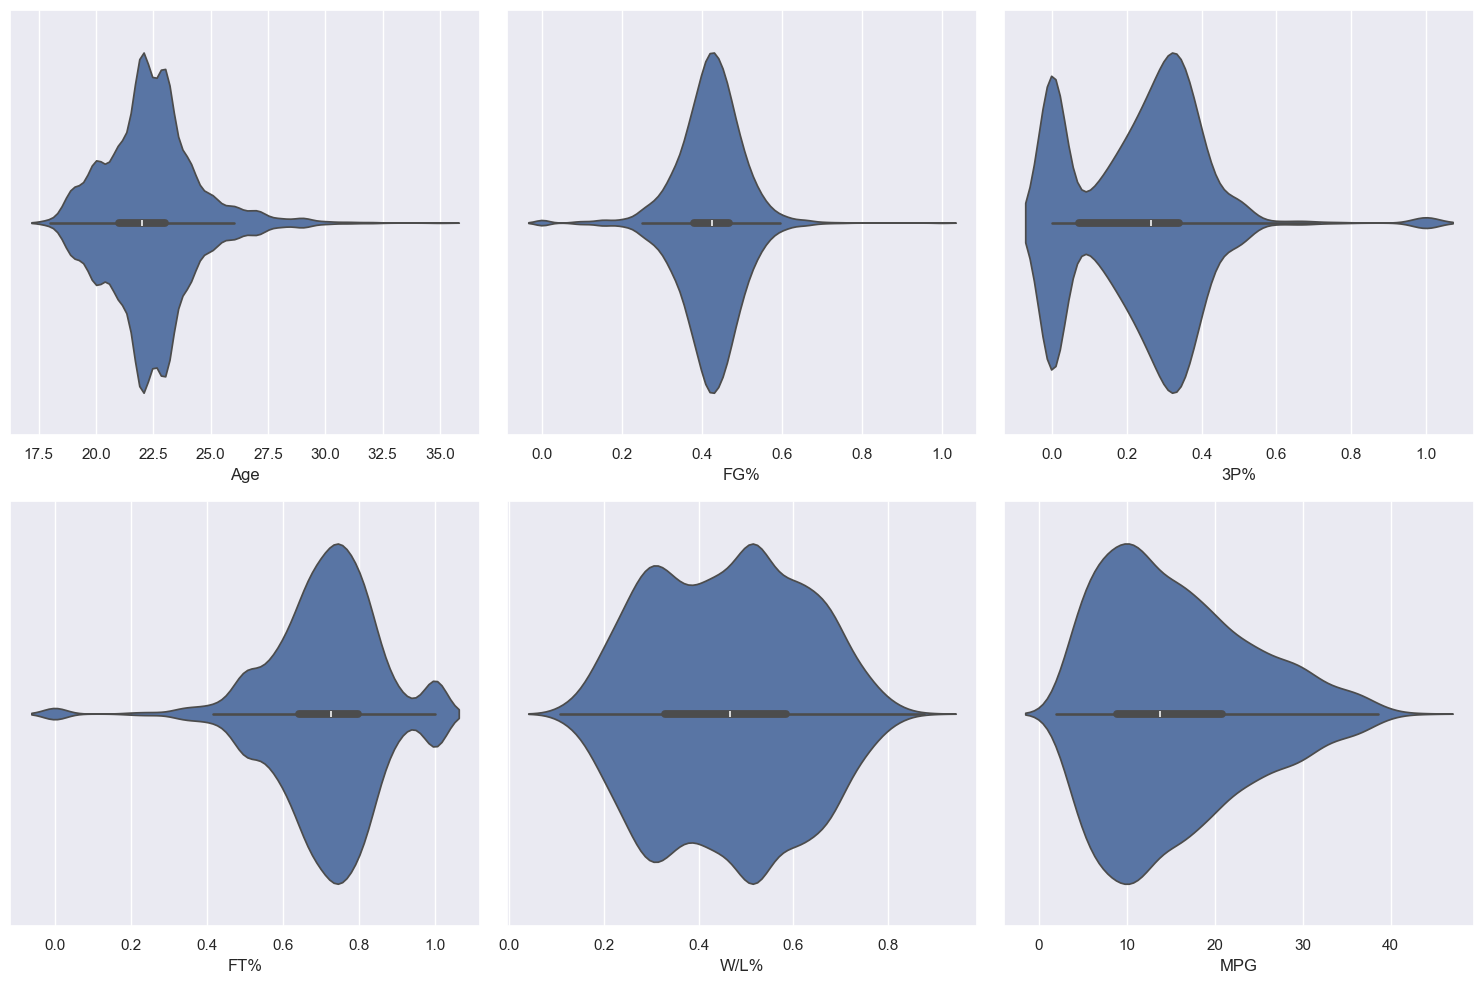

In [13]:
num_vars = ['Age', 'FG%', '3P%', 'FT%', 'W/L%', 'MPG']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.violinplot(x=var, data=df, ax=axs[i])

fig.tight_layout()

plt.show()

<Axes: >

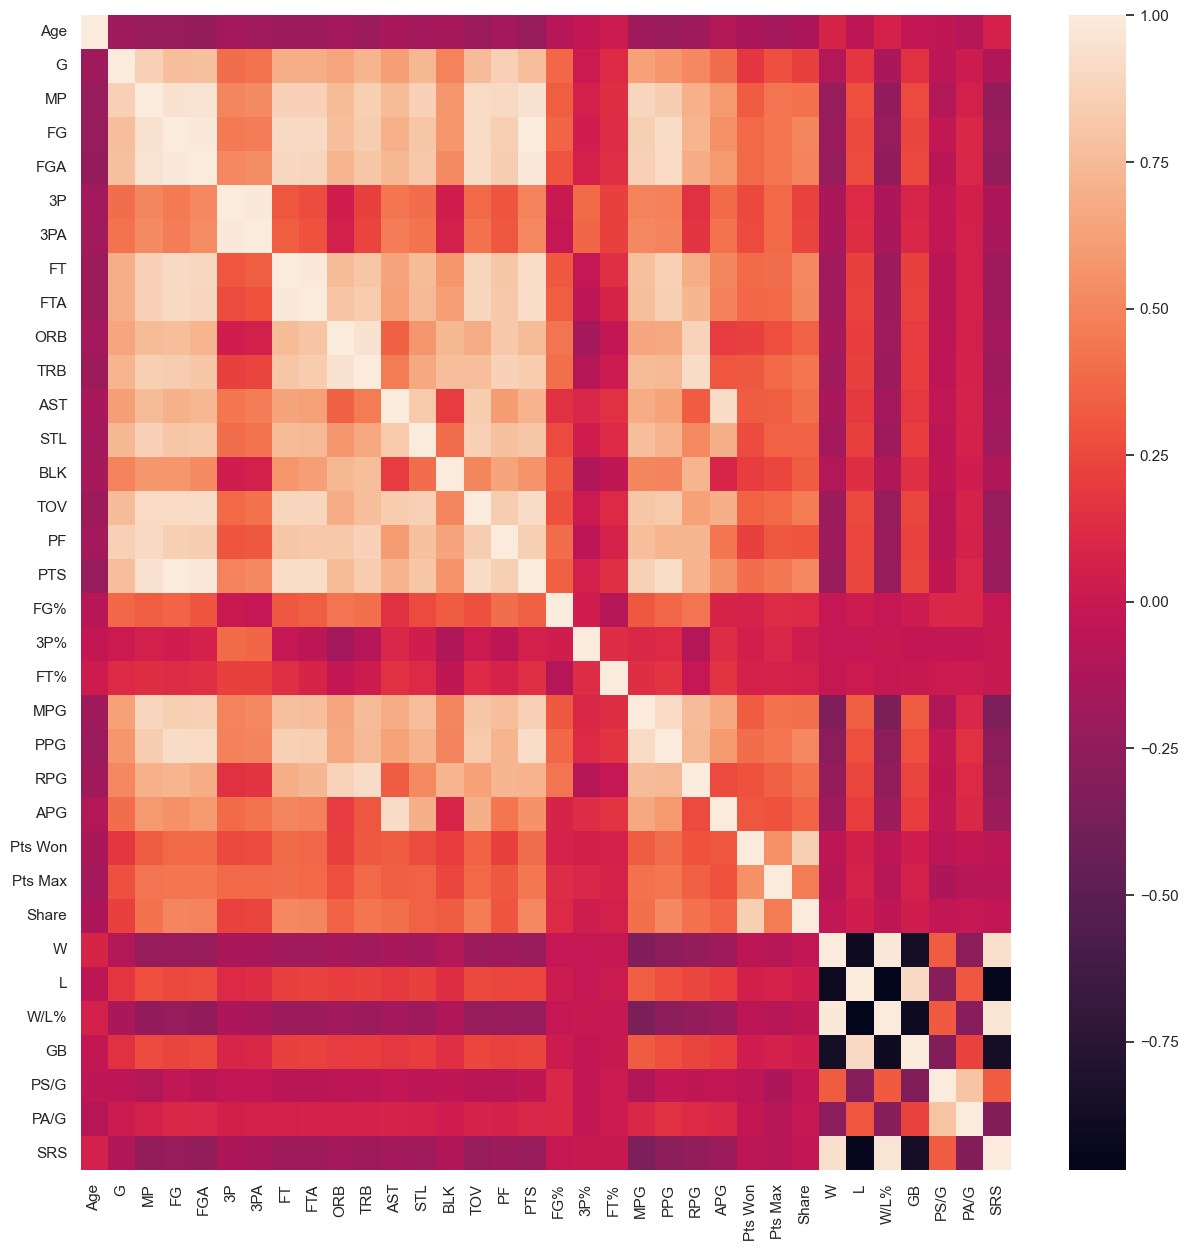

In [14]:
num_vars = df.columns[df.dtypes != 'object']

#Correlation Heatmap

df_num_vars = df[num_vars].drop(['index', 'Yrs', 'Year', 'Winner', 'Winner_Rookie'], axis=1)

plt.figure(figsize=(15, 15))
sns.heatmap(df_num_vars.corr(), fmt='.2g', annot=False)


# 2. Training, cross-validation, test sets

In [15]:
X = df.drop(['index', 'Player', 'Team', 'Yrs', 'Year', 'Winner_Rookie'], axis=1)
y = df['Winner_Rookie']

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(10, size=1)[0], shuffle=True)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=np.random.randint(10, size=1)[0], shuffle=True)

In [16]:
# check the balance of the target variable in full dataset is kept in the train, cv, test sets

print(y_train.value_counts())
print(y_cv.value_counts())
print(y_test.value_counts())

Winner_Rookie
0    1930
1      36
Name: count, dtype: int64
Winner_Rookie
0    241
1      5
Name: count, dtype: int64
Winner_Rookie
0    241
1      5
Name: count, dtype: int64


# 3 Model

## 3.1 Decision Tree

In [17]:
dtree = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
values = grid_search.best_params_

print(grid_search.best_params_)

{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3}


In [18]:
dtree_best = DecisionTreeClassifier(random_state=0, max_depth=values.get('max_depth'), min_samples_leaf=values.get('min_samples_leaf'),
                                    min_samples_split=values.get('min_samples_split'))
dtree_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=3,
                       random_state=0)

In [19]:
y_pred_train = dtree_best.predict(X_train)

print("Training Set")
print("Accuracy Score :", round(accuracy_score(y_train, y_pred_train)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_train, y_pred_train, average='micro')))
print('Precision Score : ',(precision_score(y_train, y_pred_train, average='micro')))
print('Recall Score : ',(recall_score(y_train, y_pred_train, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_train, y_pred_train, average='micro')))
print('Log Loss : ',(log_loss(y_train, y_pred_train)))

y_pred_cv = dtree_best.predict(X_cv)

print("\nCross-validation Set")
print("Accuracy Score :", round(accuracy_score(y_cv, y_pred_cv)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_cv, y_pred_cv, average='micro')))
print('Precision Score : ',(precision_score(y_cv, y_pred_cv, average='micro')))
print('Recall Score : ',(recall_score(y_cv, y_pred_cv, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_cv, y_pred_cv, average='micro')))
print('Log Loss : ',(log_loss(y_cv, y_pred_cv)))

y_pred_test = dtree_best.predict(X_test)

print("\nTest Set")
print("Accuracy Score :", round(accuracy_score(y_test, y_pred_test)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred_test, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred_test, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred_test, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred_test, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred_test)))

Training Set
Accuracy Score : 99.8 %
F-1 Score :  0.9979654120040692
Precision Score :  0.9979654120040692
Recall Score :  0.9979654120040692
Jaccard Score :  0.9959390862944163
Log Loss :  0.07333398451498933

Cross-validation Set
Accuracy Score : 98.78 %
F-1 Score :  0.9878048780487805
Precision Score :  0.9878048780487805
Recall Score :  0.9878048780487805
Jaccard Score :  0.9759036144578314
Log Loss :  0.43955674864777033

Test Set
Accuracy Score : 100.0 %
F-1 Score :  1.0
Precision Score :  1.0
Recall Score :  1.0
Jaccard Score :  1.0
Log Loss :  2.2204460492503136e-16


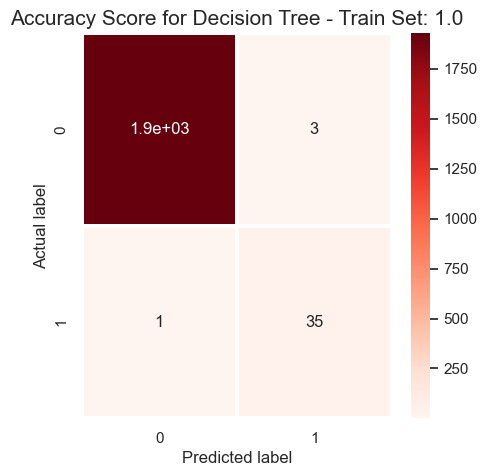

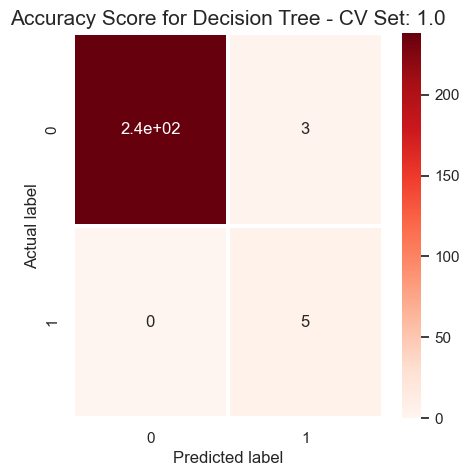

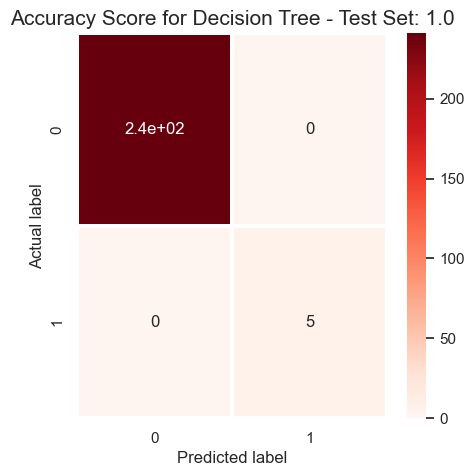

In [20]:
conf_mtx = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - Train Set: {0}'.format(dtree_best.score(X_train, y_pred_train))
plt.title(all_sample_title, size = 15)


conf_mtx = confusion_matrix(y_cv, y_pred_cv)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - CV Set: {0}'.format(dtree_best.score(X_cv, y_pred_cv))
plt.title(all_sample_title, size = 15)


conf_mtx = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - Test Set: {0}'.format(dtree_best.score(X_test, y_pred_test))
plt.title(all_sample_title, size = 15)

plt.show()

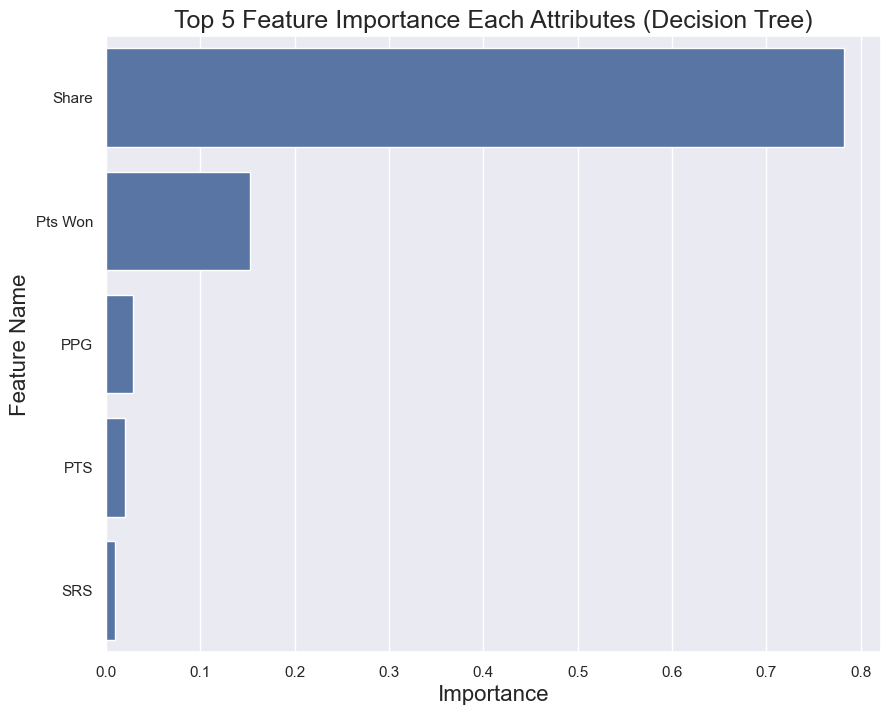

In [21]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree_best.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(5)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 5 Feature Importance Each Attributes (Decision Tree)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

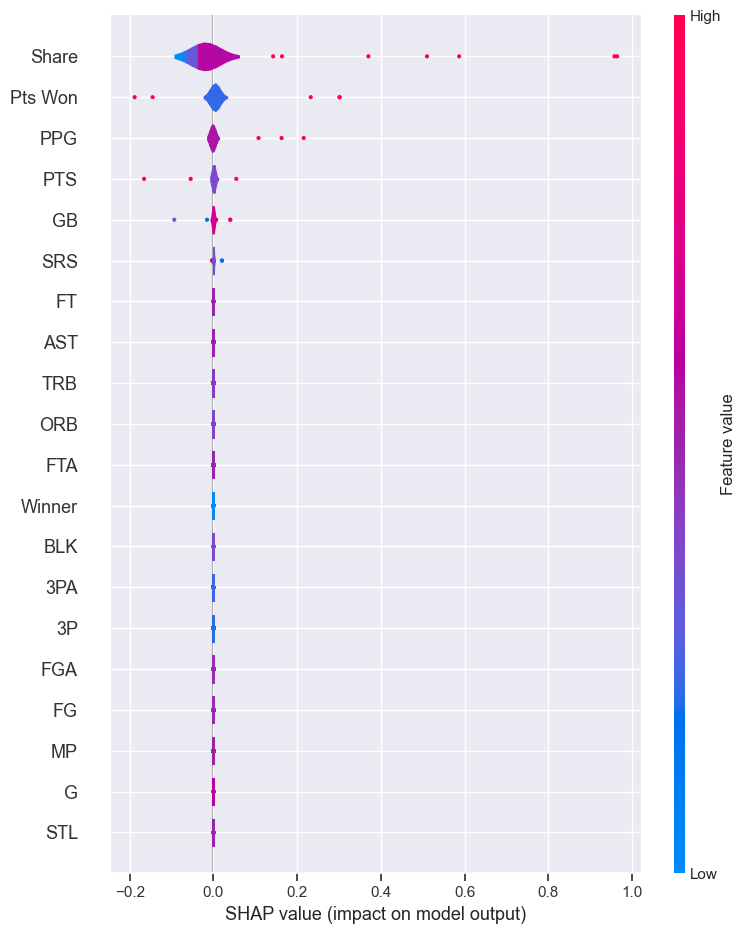

In [22]:
explainer = shap.TreeExplainer(dtree_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns, plot_type="violin")

## 3.2 Random Forest

In [23]:
rfc = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
values = grid_search.best_params_

print(grid_search.best_params_)

{'max_depth': None, 'max_features': None, 'n_estimators': 100}


In [24]:
rfc_best = RandomForestClassifier(random_state=0, max_features=values.get('max_features'), n_estimators=values.get('n_estimators'),
                                  max_depth=values.get('max_depth'))
rfc_best.fit(X_train, y_train)

RandomForestClassifier(max_features=None, random_state=0)

In [25]:
y_pred_train = rfc_best.predict(X_train)

print("Training Set")
print("Accuracy Score :", round(accuracy_score(y_train, y_pred_train)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_train, y_pred_train, average='micro')))
print('Precision Score : ',(precision_score(y_train, y_pred_train, average='micro')))
print('Recall Score : ',(recall_score(y_train, y_pred_train, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_train, y_pred_train, average='micro')))
print('Log Loss : ',(log_loss(y_train, y_pred_train)))

y_pred_cv = rfc_best.predict(X_cv)

print("\nCross-validation Set")
print("Accuracy Score :", round(accuracy_score(y_cv, y_pred_cv)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_cv, y_pred_cv, average='micro')))
print('Precision Score : ',(precision_score(y_cv, y_pred_cv, average='micro')))
print('Recall Score : ',(recall_score(y_cv, y_pred_cv, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_cv, y_pred_cv, average='micro')))
print('Log Loss : ',(log_loss(y_cv, y_pred_cv)))

y_pred_test = rfc_best.predict(X_test)

print("\nTest Set")
print("Accuracy Score :", round(accuracy_score(y_test, y_pred_test)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred_test, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred_test, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred_test, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred_test, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred_test)))

Training Set
Accuracy Score : 100.0 %
F-1 Score :  1.0
Precision Score :  1.0
Recall Score :  1.0
Jaccard Score :  1.0
Log Loss :  2.2204460492503136e-16

Cross-validation Set
Accuracy Score : 100.0 %
F-1 Score :  1.0
Precision Score :  1.0
Recall Score :  1.0
Jaccard Score :  1.0
Log Loss :  2.2204460492503136e-16

Test Set
Accuracy Score : 98.78 %
F-1 Score :  0.9878048780487805
Precision Score :  0.9878048780487805
Recall Score :  0.9878048780487805
Jaccard Score :  0.9759036144578314
Log Loss :  0.43955674864777033


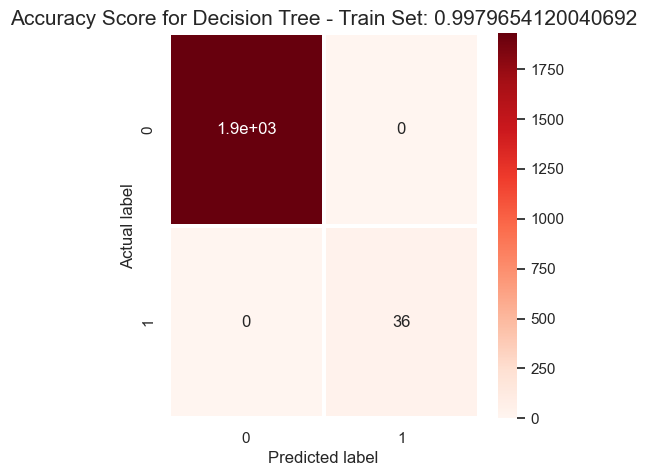

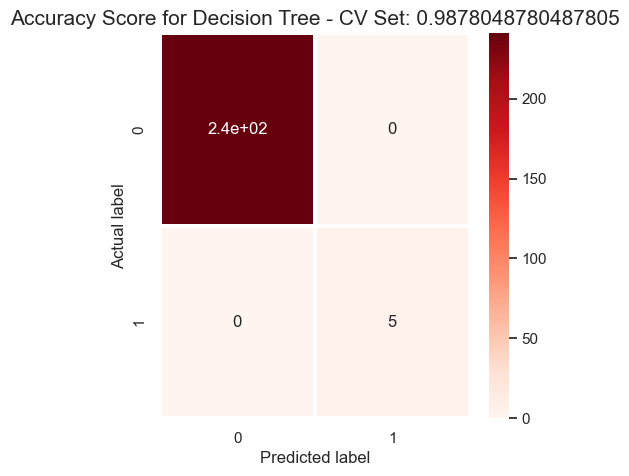

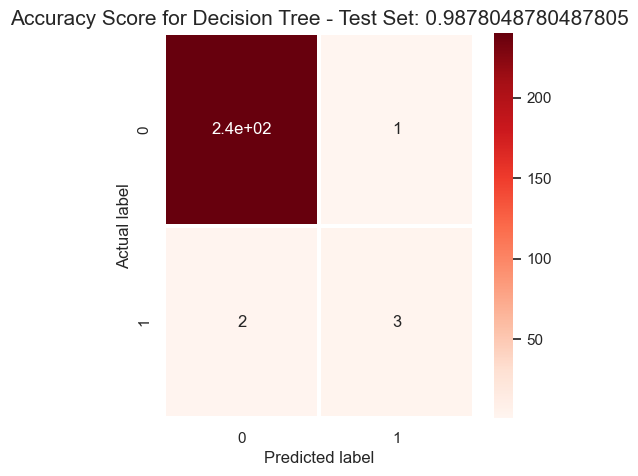

In [26]:
conf_mtx = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - Train Set: {0}'.format(dtree_best.score(X_train, y_pred_train))
plt.title(all_sample_title, size = 15)


conf_mtx = confusion_matrix(y_cv, y_pred_cv)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - CV Set: {0}'.format(dtree_best.score(X_cv, y_pred_cv))
plt.title(all_sample_title, size = 15)


conf_mtx = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,5))

sns.heatmap(data=conf_mtx,linewidths=1.5, annot=True,  cmap = 'Reds')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree - Test Set: {0}'.format(dtree_best.score(X_test, y_pred_test))
plt.title(all_sample_title, size = 15)

plt.show()

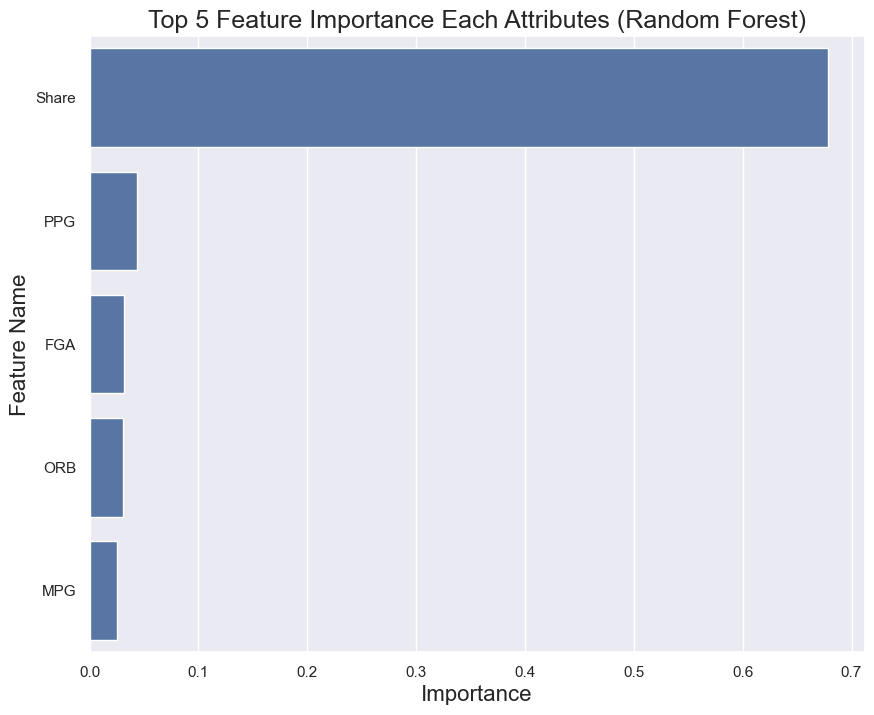

In [27]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": rfc_best.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(5)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 5 Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

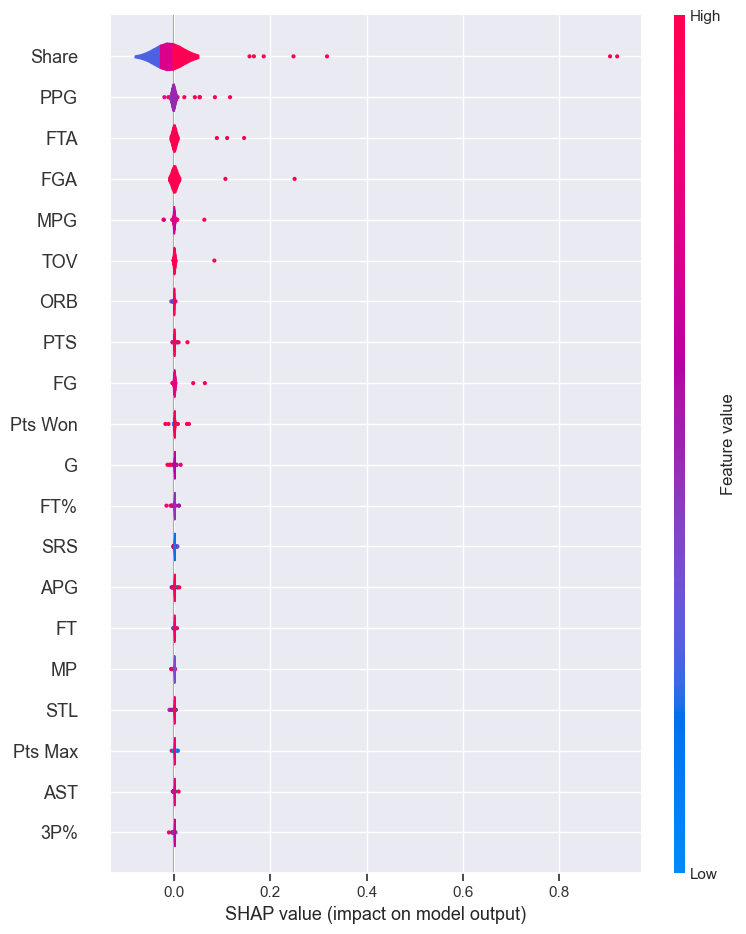

In [28]:
import shap

explainer = shap.TreeExplainer(rfc_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns, plot_type="violin")